In [1]:
import os
if "ACCEPT_TC" not in os.environ:
    os.environ["ACCEPT_TC"] = "tôi đồng ý"
from datetime import datetime
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from vnstock3 import Vnstock
import pandas_ta as ta
import numpy as np
import F 


In [2]:
now = datetime.now()
current_date = now.strftime("%Y-%m-%d")
vn30 = Vnstock().stock(symbol='VN30', source='VCI')
df_vn30 = vn30.quote.history(start='2020-08-01', end = current_date, to_df=True)

vni = Vnstock().stock(symbol='VNINDEX', source='VCI')
df_vni = vni.quote.history(start='2020-08-01', end = current_date, to_df=True)

2024-06-23 17:41:03,856 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS
2024-06-23 17:41:04,395 - vnstock3.common.data.data_explorer - WARNING - Thông tin niêm yết & giao dịch sẽ được truy xuất từ TCBS


In [3]:
def process_data(data):
    data['time'] = pd.to_datetime(data['time'])
    data.sort_values(by='time', ascending=True, inplace=True)
    data.reset_index()
    
    data['close'] = pd.to_numeric(data['close'], errors='coerce')
    data['sma5'] = ta.sma(data['close'], length=5)
    data['sma10'] = ta.sma(data['close'], length=10)

    # Thêm chỉ báo EMA
    data['ema5'] = ta.ema(data['close'], length=5)
    data['ema10'] = ta.ema(data['close'], length=10)

    # Thêm chỉ báo RSI
    data['rsi'] = ta.rsi(data['close'], length=14)

    # Thêm chỉ báo MACD
    data.ta.macd(close='close', fast=12, slow=26, signal=9, append=True)

    data.dropna(inplace=True)
    data.reset_index()
    return data

In [4]:
data_VN30 = process_data(df_vn30)
data_VNI = process_data(df_vni)

In [5]:
def model_ARIMA(data):
    data = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    stepwise_model = auto_arima(data['close'], trace=True, suppress_warnings=True, stepwise=True)
    model = ARIMA(data['close'], order=stepwise_model.order)
    model_fit = model.fit()
    return model_fit

def output_ARIMA(data, trend):
    data = data.head(trend)
    data_features = data[['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
    if data_features.isnull().values.any():
        raise ValueError("Train data contains NaN values.")
    
    model = model_ARIMA(data_features)
    next_day_forecast = model.forecast(steps=10)
    
    return np.mean(next_day_forecast)

In [6]:
def test(data, k):
    # Ensure the 'Price' column is properly referenced
    data_output = data[['time', 'close']].copy()
    data_output['position'] = 0

    # Calculate predicted price for each row starting from index k
    for i in range(k, len(data)):
        # Get data for the previous k days to predict the price for the current day
        historical_data = data.iloc[i-k:i][['close','sma5','sma10','ema5','ema10','rsi','MACD_12_26_9','MACDh_12_26_9','MACDs_12_26_9']]
        
        # Assuming output_ARIMA returns the predicted price based on previous data
        predicted_price = output_ARIMA(historical_data, k)
        
        # Calculate the price difference between the last day in the prediction data and the predicted price
        price_difference = predicted_price - data.iloc[i-1]['close']  # Make sure 'price' is correctly referenced

        # Update position based on calculated price difference
        if price_difference > 2:
            data_output.loc[i, 'position'] = 1
        elif price_difference < 2:
            data_output.loc[i, 'position'] = -1
    data_output.dropna(inplace = True)
    return data_output

In [7]:
%%capture
data_VNI_position = test(data_VNI, 200)
data_VN30_position = test(data_VN30, 200)

Margin: 45.1430813268742
MDD: (605.831929637527, 0.4235165326586369)

   Total trading quantity: 11
         Profit per trade: 10.24090909090914
             Total Profit: 112.7
         Profit after fee: 108.2
 Trading quantity per day: 0.011727078891257996
 Profit per day after fee: 0.11535181236673775
                   Return: 0.020107950054037347
          Profit per year: 28.764020393299344
                  HitRate: 0.2727272727272727
          HitRate per day: 0.35859124866595515


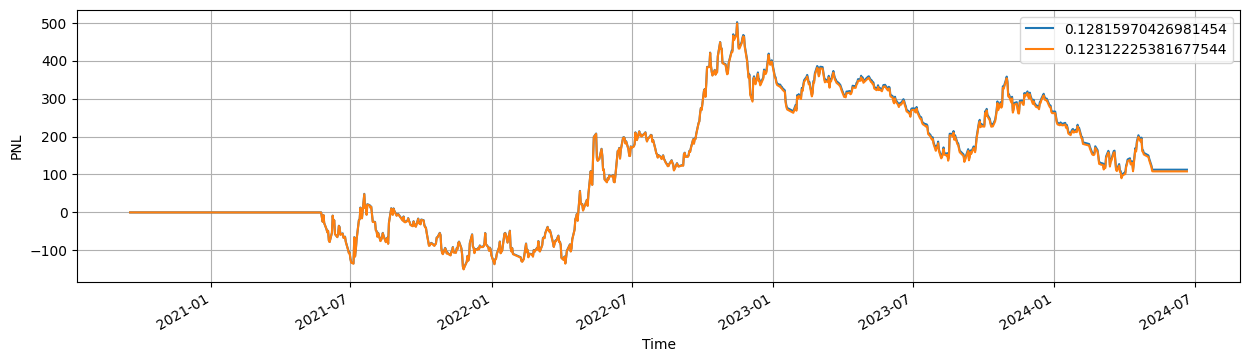

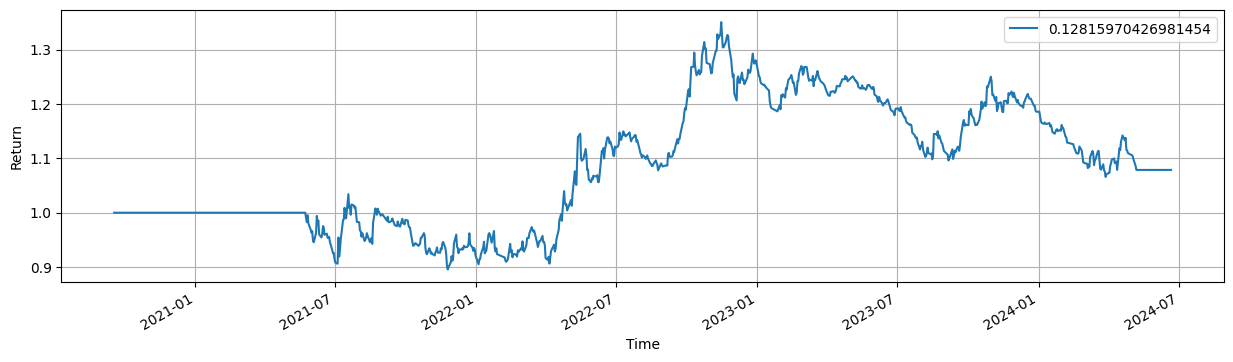

In [8]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: 20.615204551294717
MDD: (499.50261194029804, 0.38483074619046365)

   Total trading quantity: 25
         Profit per trade: 4.280799999999999
             Total Profit: 107.0
         Profit after fee: 96.9
 Trading quantity per day: 0.026652452025586353
 Profit per day after fee: 0.10330490405117271
                   Return: 0.019846233814575256
          Profit per year: 25.76001456664239
                  HitRate: 0.56
          HitRate per day: 0.3511205976520811


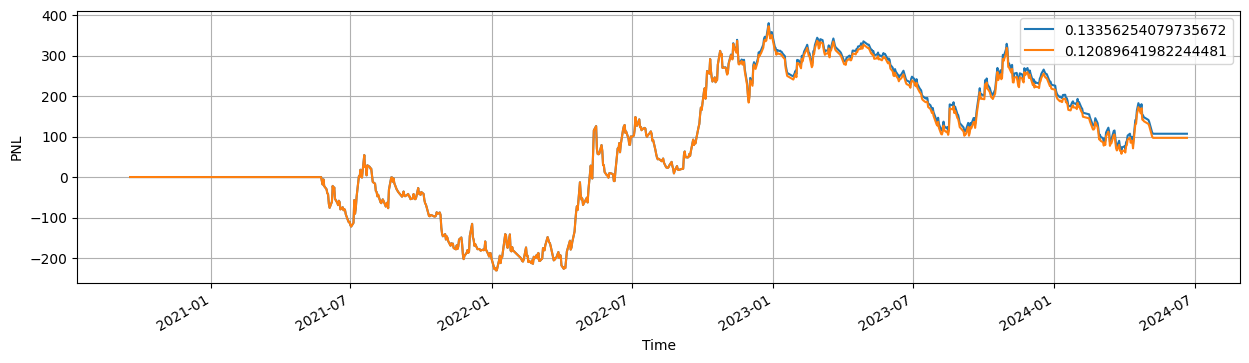

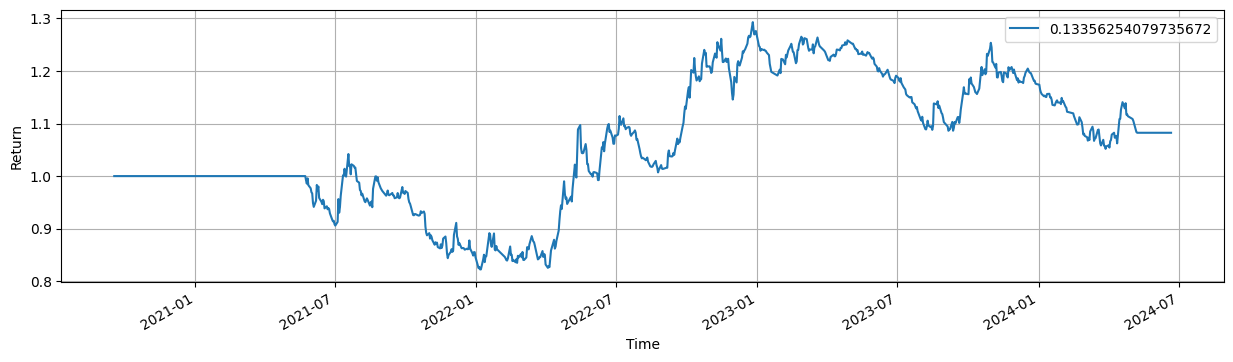

In [9]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()

In [13]:
%%capture
data_VNI_position = test(data_VNI, 30)
data_VN30_position = test(data_VN30, 30)

Margin: -31.784649539765823
MDD: (1132.2262793176958, 1.3458696233241754)

   Total trading quantity: 103
         Profit per trade: -8.00048543689322
             Total Profit: -824.1
         Profit after fee: -867.5
 Trading quantity per day: 0.10980810234541578
 Profit per day after fee: -0.9248400852878464
                   Return: -0.2741331591555891
          Profit per year: -230.61726147123088
                  HitRate: 0.39805825242718446
          HitRate per day: 0.4279615795090715


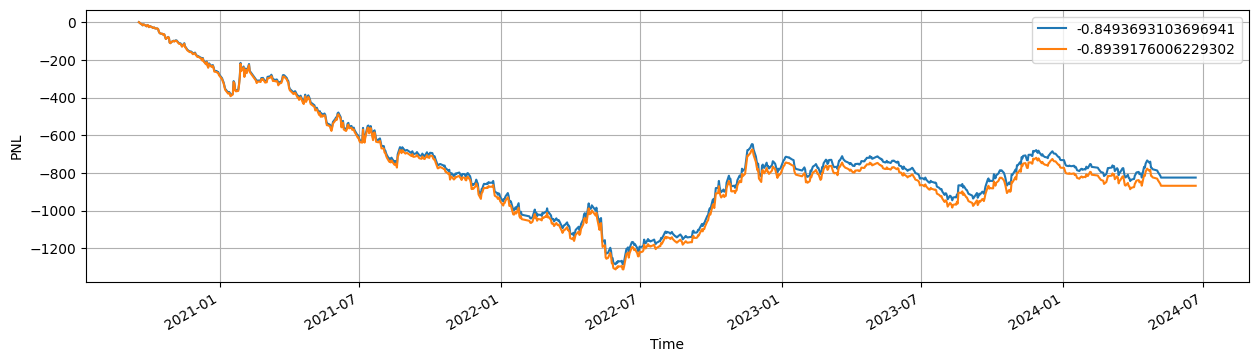

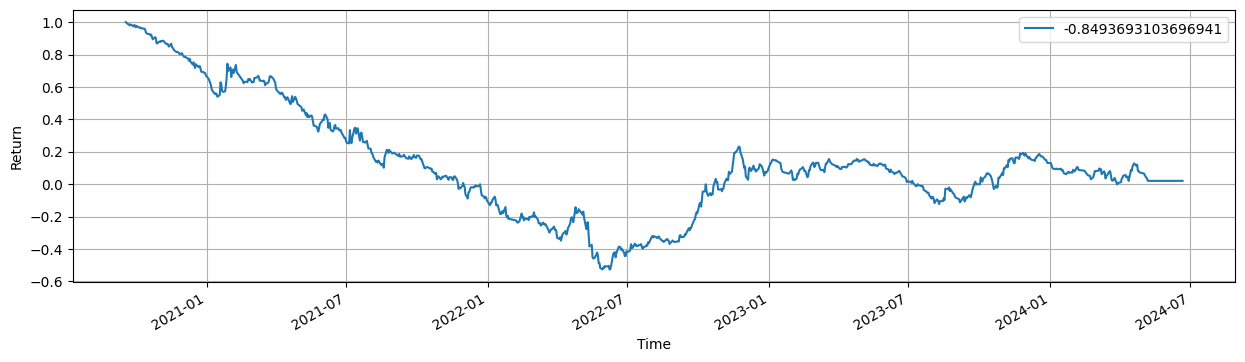

In [14]:
backtesting = F.BacktestInformation(data_VN30_position['time'], data_VN30_position['position'], data_VN30_position['close'])
backtest = backtesting.Plot_PNL()

Margin: -16.912539280004246
MDD: (799.2850746268656, 0.8871580827203125)

   Total trading quantity: 83
         Profit per trade: -4.15240963855421
             Total Profit: -344.6
         Profit after fee: -379.3
 Trading quantity per day: 0.08848614072494669
 Profit per day after fee: -0.4043710021321962
                   Return: -0.11191916988812528
          Profit per year: -100.83357611070647
                  HitRate: 0.4457831325301205
          HitRate per day: 0.4279615795090715


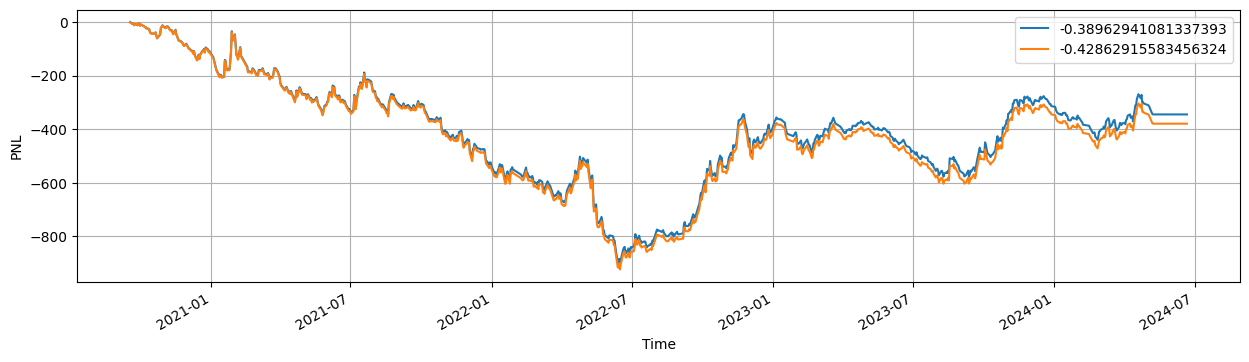

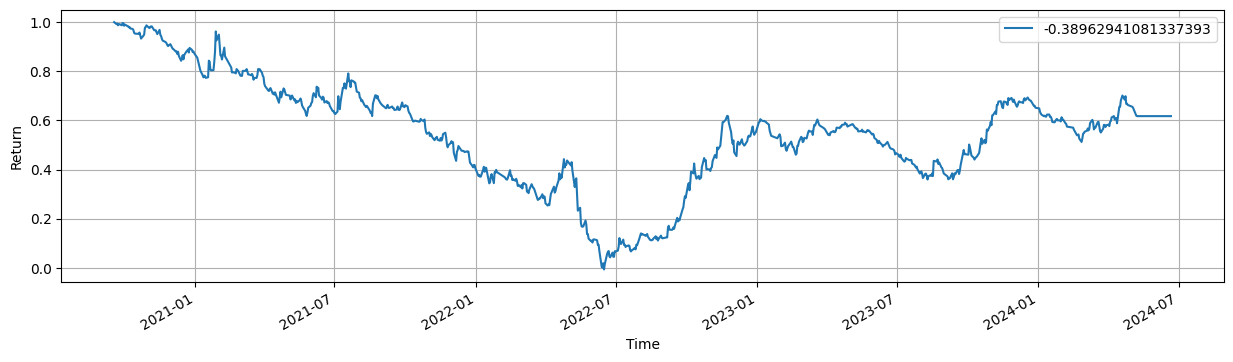

In [15]:
backtesting = F.BacktestInformation(data_VNI_position['time'], data_VNI_position['position'], data_VNI_position['close'])
backtest = backtesting.Plot_PNL()